In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from IPython.display import clear_output
import tensorflow_addons as tfa
import time
import pathlib
autotune = tf.data.AUTOTUNE
tf.config.run_functions_eagerly(True)

2021-11-20 04:19:20.281331: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/qc/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
BASE_PATH = "./categorical-west/"
TAR_BASE_PATH = "./categorical-east/"
NUM_CLASSES = 4
im_height, im_width = 256, 256
BATCH_SIZE = 4

In [3]:
# Extrac name of files
files = os.listdir(BASE_PATH)
tar_files = os.listdir(TAR_BASE_PATH)
files = [BASE_PATH + f for f in files]
tar_files = [TAR_BASE_PATH + f for f in tar_files]
print("###SRC FILES###")
print(BASE_PATH)
print(len(files))
print("###TAR FILES###")
print(TAR_BASE_PATH)
print(len(tar_files))

###SRC FILES###
./categorical-west/
1188
###TAR FILES###
./categorical-east/
425


In [4]:
class DataGenerator(keras.utils.Sequence):
    'Generate data for keras'
    def __init__(self, image_paths, batch_size, augment, shuffle, normalize=False, 
                minimum=0, maximum=0):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.normalize = normalize
        self.minimum = minimum
        self.maximum = maximum
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_paths) / self.batch_size))
  

    def on_epoch_end(self):
        'Updates indices after each epoch'
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
              np.random.shuffle(self.indices)
  
    def __getitem__(self, index):
        'Generate one batch of data'
        # select indices of data for next batch
        indices = self.indices[index*self.batch_size: (index+1)*self.batch_size]

        # select data and load images
        imgs_lbls = []
        for i in indices:
            img_lbl = np.load(self.image_paths[i])
            # img_lbl = np.moveaxis(img_lbl, 0, -1)
            imgs_lbls.append(img_lbl)

        # preprocess and augment data
        if self.augment:
            img_lbls = self.augmentor(imgs_lbls)
    
        images = []
        labels = []
        for img_lbl in imgs_lbls:
            image = img_lbl[:12, :, :]
            image = np.moveaxis(image, 0, -1)
            images.append(image)
            label = img_lbl[12:, :, :]
            label = np.moveaxis(label, 0, -1)
            labels.append(label)
        images = np.array(images, dtype=np.float32)
        if self.normalize:
            images = 2 * ((images - self.minimum) / (self.maximum - self.minimum)) - 1
        return images, np.array(labels, dtype=np.float32)
  
    def augmentor(self, imgs_lbls):
        k = np.random.randint(0, 4)
        imgs_lbls = [np.rot90(img_lbl, axes=(0, 1), k=k) for img_lbl in imgs_lbls]

        if k % 2 == 0:
            imgs_lbls = [np.fliplr(img_lbl) for img_lbl in imgs_lbls]
        else:
            imgs_lbls = [np.flipud(img_lbl) for img_lbl in imgs_lbls]
    

        return imgs_lbls

In [5]:
maximum, minimum = 14.733826, -49.208305

src_gen = DataGenerator(image_paths=files, batch_size=BATCH_SIZE,  augment=True, 
                          shuffle=True, normalize=True, maximum=maximum, minimum=minimum)

tar_gen = DataGenerator(image_paths=tar_files, batch_size=BATCH_SIZE, augment=True, shuffle=True,
                         normalize=True, maximum=maximum, minimum=minimum)



In [6]:
x, y = src_gen[0]
x.shape, y.shape

((4, 256, 256, 12), (4, 256, 256, 4))

In [7]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset


def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


def unet_generator(output_channels, norm_type='batchnorm'):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
  Returns:
    Generator model
  """

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
#       downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
#       downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
#       downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  ]

  up_stack = [
#       upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
#       upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
#       upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 12])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


def discriminator(norm_type='batchnorm', target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
  Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.
  Returns:
    Discriminator model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 12], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 12], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)


def get_checkpoint_prefix():
  checkpoint_dir = './training_checkpoints'
  checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

  return checkpoint_prefix

In [8]:
from keras_unet_collection.keras_unet_collection import models

d_model, model = models.unet_2d((256, 256, 12), [16, 32, 32, 64], n_labels=NUM_CLASSES,
                      stack_num_down=2, stack_num_up=1,
                      activation='GELU', output_activation='Softmax', 
                      batch_norm=True, pool='max', unpool='nearest', name='unet',
                      is_domain_adaptation=False, da_type='conv2d', da_kernels=[32, 16])

def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first


        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(i, classSelectors) for i in np.arange(len(weightsList), dtype='int64')]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc


other = 17749814 + 17766350 + 22149798
corn = 204516 + 172453 + 235173
cotton = 88734 + 26780 + 1677
rice = 10122026 + 6884977 + 7128782
total = other + corn + cotton + rice 

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_other = (1 / other) * (total / 2.0)
weight_for_corn = (1 / corn) * (total / 2.0)
weight_for_cotton = (1 / cotton) * (total / 2.0)
weight_for_rice = (1 / rice) * (total / 2.0)

class_weight = {0: weight_for_other, 1: weight_for_corn, 2: weight_for_cotton, 3: weight_for_rice}

print('Weight for class 0: {:.2f}'.format(weight_for_other))
print('Weight for class 1: {:.2f}'.format(weight_for_corn))
print('Weight for class 2: {:.2f}'.format(weight_for_cotton))
print('Weight for class 3: {:.2f}'.format(weight_for_rice))

weights = [weight_for_other, weight_for_corn, weight_for_cotton, weight_for_rice]

model.trainable = False
model.compile(optimizer='adam', 
              loss=weightedLoss(keras.losses.categorical_crossentropy, weights),
              metrics=['accuracy'])

model.load_weights('./UnetCheckpoint/checkpoint')

2021-11-20 04:19:35.043076: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-20 04:19:35.043738: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-20 04:19:35.078055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 04:19:35.078459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-11-20 04:19:35.078490: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-20 04:19:35.079698: I tensorflow/stream_executor/platform/de

Weight for class 0: 0.72
Weight for class 1: 67.41
Weight for class 2: 352.12
Weight for class 3: 1.71


In [9]:
OUTPUT_CHANNELS = 12

generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)


In [10]:
sample_src, y_src = src_gen[0]
sample_tar, y_tar = tar_gen[0]

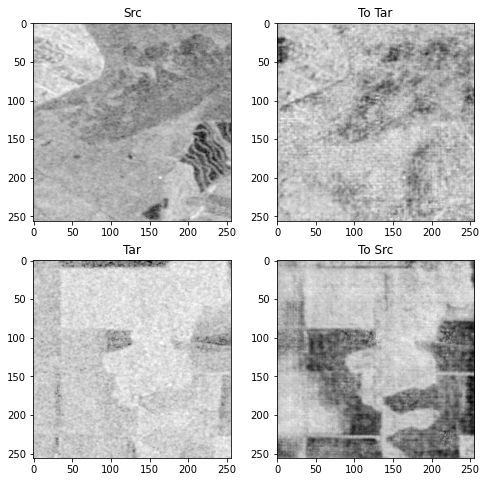

In [25]:
to_tar = generator_g(sample_src)
to_src = generator_f(sample_tar)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_src, to_tar, sample_tar, to_src]
title = ['Src', 'To Tar', 'Tar', 'To Src']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0][:, :, 0] * 0.5 + 0.5, cmap='gray')
  else:
    plt.imshow(imgs[i][0][:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()


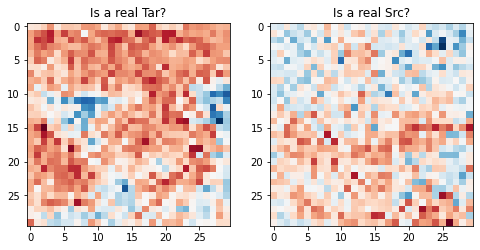

In [12]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real Tar?')
plt.imshow(discriminator_y(sample_tar)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real Src?')
plt.imshow(discriminator_x(sample_src)[0, ..., -1], cmap='RdBu_r')

plt.show()


In [13]:
LAMBDA = 10


In [14]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real)*0.99, real)

  generated_loss = loss_obj(tf.zeros_like(generated)+0.01, generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5


In [16]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated)*0.99, generated)


In [17]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [18]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [19]:
def image_comparison(im1, im2):
    loss = tf.reduce_mean(tf.abs(im1 - im2))
    return LAMBDA * 0.5 * loss

In [20]:
def image_similarity_loss(original, generated):
    loss = 0.0
    for i in range(original.shape[0]):
        for channel in range(11):
            comparison_orig = image_comparison(original[i, :, :, channel:channel+1], original[i, :, :, channel+1:channel+2])
            comparison_gen = image_comparison(generated[i, :, :, channel:channel+1], generated[i, :, :, channel+1:channel+2])
            loss = loss + tf.abs(comparison_orig - comparison_gen)
    
    return LAMBDA * 0.5 * loss

In [21]:
def semantic_loss(generated_image, y):
    loss, _ = model.evaluate(x=x, y=y, verbose=0)
    return loss

In [22]:
semantic_loss(to_tar, y_src)

/home/qc/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2021-11-20 04:19:55.097398: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-20 04:19:55.117863: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


7.704882621765137

In [23]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [24]:
checkpoint_path = "./enhanced_cycle_gan1/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


Latest checkpoint restored!!


In [25]:
EPOCHS = 100


In [26]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i][:, :, 0] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')
  plt.show()


In [27]:
gen_g_losses = []
gen_f_losses = []
dis_g_losses = []
dis_f_losses = []

In [28]:
@tf.function
def train_step(real_x, label_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y) + image_similarity_loss(real_x, fake_y) + semantic_loss(fake_y, label_x)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x) + image_similarity_loss(real_y, fake_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
    
  gen_g_losses.append(total_gen_g_loss)
  gen_f_losses.append(total_gen_f_loss)
  dis_g_losses.append(disc_x_loss)
  dis_f_losses.append(disc_y_loss)


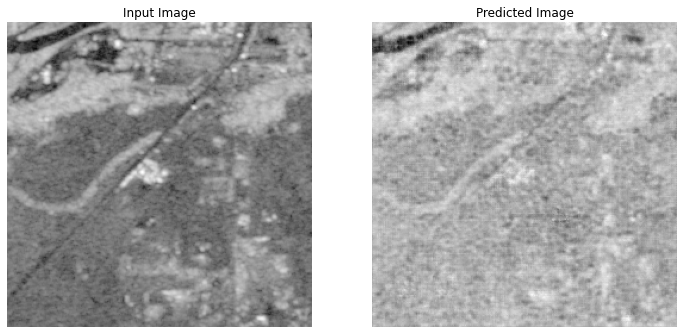

Time taken for epoch 29 is 314.8774666786194 sec

.................

2021-11-19 13:05:59.505287: W tensorflow/core/common_runtime/bfc_allocator.cc:433] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.00MiB (rounded to 33554432)requested by op Conv2D
Current allocation summary follows.
2021-11-19 13:05:59.506995: I tensorflow/core/common_runtime/bfc_allocator.cc:972] BFCAllocator dump for GPU_0_bfc
2021-11-19 13:05:59.507029: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (256): 	Total Chunks: 36239, Chunks in use: 36236. 8.85MiB allocated for chunks. 8.85MiB in use in bin. 164.7KiB client-requested in use in bin.
2021-11-19 13:05:59.507053: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (512): 	Total Chunks: 54, Chunks in use: 54. 27.8KiB allocated for chunks. 27.8KiB in use in bin. 27.0KiB client-requested in use in bin.
2021-11-19 13:05:59.507065: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (1024): 	Total Chunks: 73, Chunks in use: 73. 79.2KiB allocated for chunks. 79.2KiB in use in bin. 73.0KiB cli

ResourceExhaustedError: OOM when allocating tensor with shape[4,128,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

In [29]:
for epoch in range(EPOCHS-69):
  start = time.time()

  n = 0
  for i in range(len(src_gen)):
    image_x, label_x = src_gen[i]
    i = i % len(tar_gen)
    image_y, _ = tar_gen[i]
    train_step(image_x, label_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_src) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_src)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))


In [ ]:
generator_g_losses = [loss.numpy() for loss in gen_g_losses]
generator_f_losses = [loss.numpy() for loss in gen_f_losses]
discriminator_g_losses = [loss.numpy() for loss in dis_g_losses]
discriminator_f_losses = [loss.numpy() for loss in dis_g_losses]

In [ ]:
plt.plot(generator_g_losses, label="Generator G Losses")
plt.plot(generator_f_losses, label="Generator F Losses")
plt.legend()
plt.show()

In [ ]:
generate_images(generator_g, sample_src)

In [26]:
os.mkdir('src_to_tar1')
os.mkdir('tar_to_src1')

In [27]:
maximum, minimum = 14.733826, -49.208305

src_gen = DataGenerator(image_paths=files, batch_size=1,  augment=True, 
                          shuffle=True, normalize=True, maximum=maximum, minimum=minimum)

tar_gen = DataGenerator(image_paths=tar_files, batch_size=1, augment=True, shuffle=True,
                         normalize=True, maximum=maximum, minimum=minimum)



In [28]:
x, y = src_gen[0]
x.shape, y.shape

((1, 256, 256, 12), (1, 256, 256, 4))

In [29]:
x_hat = generator_g.predict(x)
x_hat.shape

/home/qc/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


(1, 256, 256, 12)

In [34]:
type(x_hat)

numpy.ndarray

In [31]:
image_label = np.c_[x_hat.squeeze(), y.squeeze()]
image_label.shape

(256, 256, 16)

In [35]:
def translation(dataset, model, path):
    for i, (x, y) in enumerate(dataset):
        prediction = model.predict(x)
        prediction = np.c_[prediction.squeeze(), y.squeeze()]
        pattern = "{}/{}.npy".format(path, i)  
        with open(pattern, 'wb') as f:
                print(pattern)
                print(prediction.shape)
                
                np.save(f, prediction)
        

translation(src_gen, generator_g, 'src_to_tar1')
# translation(tar_gen, generator_f, 'tar_to_src1')

src_to_tar1/0.npy
(256, 256, 16)
src_to_tar1/1.npy
(256, 256, 16)
src_to_tar1/2.npy
(256, 256, 16)
src_to_tar1/3.npy
(256, 256, 16)
src_to_tar1/4.npy
(256, 256, 16)
src_to_tar1/5.npy
(256, 256, 16)
src_to_tar1/6.npy
(256, 256, 16)
src_to_tar1/7.npy
(256, 256, 16)
src_to_tar1/8.npy
(256, 256, 16)
src_to_tar1/9.npy
(256, 256, 16)
src_to_tar1/10.npy
(256, 256, 16)
src_to_tar1/11.npy
(256, 256, 16)
src_to_tar1/12.npy
(256, 256, 16)
src_to_tar1/13.npy
(256, 256, 16)
src_to_tar1/14.npy
(256, 256, 16)
src_to_tar1/15.npy
(256, 256, 16)
src_to_tar1/16.npy
(256, 256, 16)
src_to_tar1/17.npy
(256, 256, 16)
src_to_tar1/18.npy
(256, 256, 16)
src_to_tar1/19.npy
(256, 256, 16)
src_to_tar1/20.npy
(256, 256, 16)
src_to_tar1/21.npy
(256, 256, 16)
src_to_tar1/22.npy
(256, 256, 16)
src_to_tar1/23.npy
(256, 256, 16)
src_to_tar1/24.npy
(256, 256, 16)
src_to_tar1/25.npy
(256, 256, 16)
src_to_tar1/26.npy
(256, 256, 16)
src_to_tar1/27.npy
(256, 256, 16)
src_to_tar1/28.npy
(256, 256, 16)
src_to_tar1/29.npy
(256,

In [ ]:
x, y = src_gen[0]
print(x.squeeze().shape, y.squeeze().shape)
prediction = generator_g(x)
prediction = prediction.numpy()
prediction = np.c_[prediction.squeeze(), y.squeeze()]
prediction.shape

In [ ]:
np.all(prediction[..., 12:] == y)